In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import RFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta

from scipy.signal import savgol_filter


dask.config.set(**{'array.slicing.split_large_chunks': True})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Training and Convolution Data Sets

In [13]:
model_set = RFutils.model_test_set

conv_id = 'ssp126'
hist_id = 'historical'
train_id = '1pctCO2'
print(f'Load {conv_id} run for convolution...')

RF_profile_conv, dN, EB_conv_dict, EB_ctrl_dict = RFutils.load_ERF_set(model_set, conv_id, print_var = True, ssp = True)
RF_profile_hist, dN, EB_hist_dict, EB_ctrl_dict = RFutils.load_ERF_set(model_set, hist_id, print_var = False, ssp = True)

A = RFutils.A
ds_out = RFutils.ds_out

RF_profile_combine = {}
for m in RF_profile_conv:
    RF_profile_conv[m] = RFutils.regrid_cmip(RF_profile_conv[m],ds_out)
    RF_profile_conv[m] = RF_profile_conv[m].weighted(A).mean(dim = ['lat','lon'])
    
    if m not in RF_profile_hist:
        raise Exception(f'Model in convolution dict not in historical dict.')
        
    RF_profile_hist[m] = RFutils.regrid_cmip(RF_profile_hist[m],ds_out)
    RF_profile_hist[m] = RF_profile_hist[m].weighted(A).mean(dim = ['lat','lon'])
    
    RF_profile_combine[m] = xr.concat([RF_profile_hist[m],RF_profile_conv[m]],dim='year')
    if len(RF_profile_combine[m]['year']) > 250:
        RF_profile_combine[m] = RF_profile_combine[m].sel(year = slice(RF_profile_combine[m]['year'].min(),RF_profile_combine[m]['year'].min()+250))

RF_ds = RFutils.concat_multirun(RF_profile_combine, 'model')

Load ssp126 run for convolution...
	 Loading NorESM2-LM data...
../cmip6_data/ssp126/rsdt_Amon_NorESM2-LM_ssp126_r1i1p1f1**
../cmip6_data/piControl/rsdt_Amon_NorESM2-LM_piControl_r1i1p1f1**
../cmip6_data/ssp126/rsut_Amon_NorESM2-LM_ssp126_r1i1p1f1**
../cmip6_data/piControl/rsut_Amon_NorESM2-LM_piControl_r1i1p1f1**
../cmip6_data/ssp126/rlut_Amon_NorESM2-LM_ssp126_r1i1p1f1**
../cmip6_data/piControl/rlut_Amon_NorESM2-LM_piControl_r1i1p1f1**
	 Loading NorESM2-LM data...


/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


### Import Green's Functions

In [15]:
G_ds_dict = {}
G_ds_path = f'../Outputs/RF_Outputs/G_{train_id}_ERF_all_ds.nc4'
#G_ds_path = f'../Outputs/RF_Outputs/G_{train_id}_F_model_NorESM2-LM_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['__xarray_dataarray_variable__']
G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})
G_ds_dict[train_id] = G_ds
    
G_ds = RFutils.concat_multirun(G_ds_dict, 'train_id')

### Process Data and Convolve

In [40]:
tas_conv = RFutils.import_regrid_tas_set(model_set, conv_id)
tas_hist = RFutils.import_regrid_tas_set(model_set, hist_id)
tas_combined = {}
for m in tas_conv.keys():
    tas_combined[m] = xr.concat([tas_hist[m], tas_conv[m]], dim='time')

tas_pictrl = RFutils.import_regrid_tas_set(model_set, 'piControl')
ds_dif, dif = RFutils.calc_tas_dif_set(tas_combined, tas_pictrl, model_set, train_id, G_ds)
conv_mean_ds = RFutils.convolve_exp_set(G_ds, RF_ds, model_set, [train_id], conv_mean = True)
conv_ds = RFutils.convolve_exp_set(G_ds, RF_ds, model_set, [train_id], conv_mean = False)

Convolving NorESM2-LM for Global Mean
NorESM-LM
Convolving NorESM2-LM Spatially


### Create Plots for Analysis

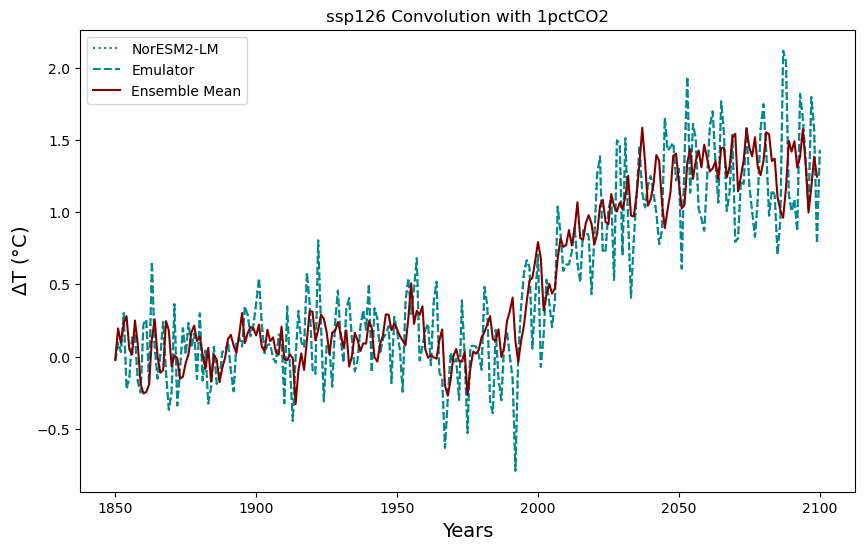

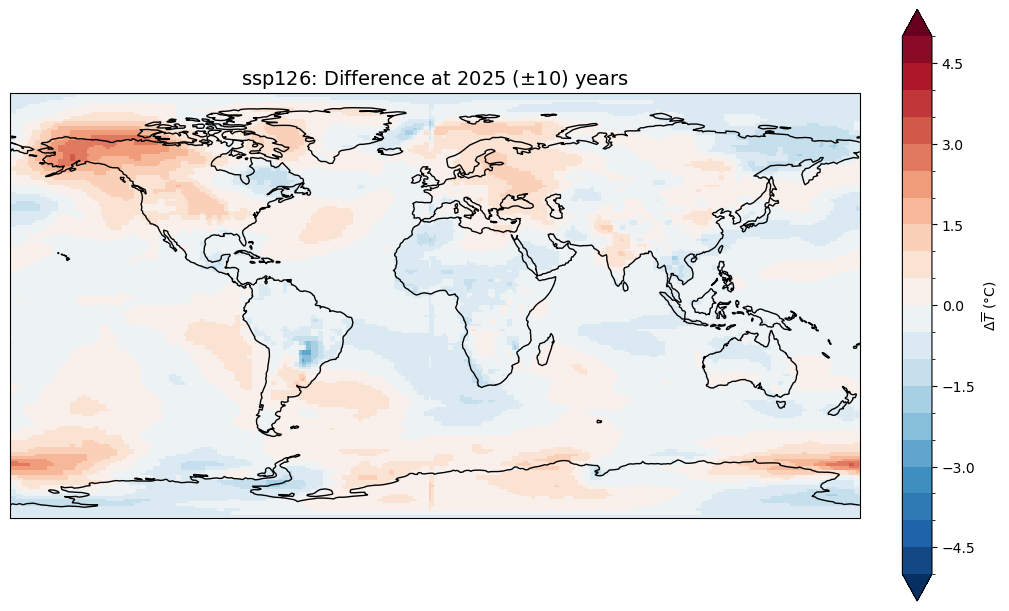

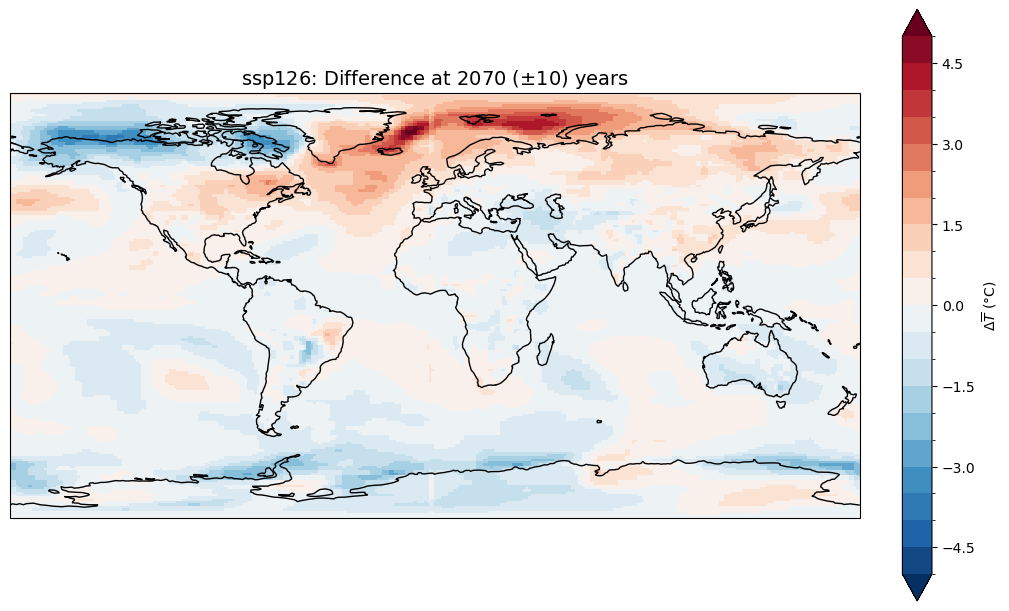

In [57]:
model_color = RFutils.model_color
type_color = RFutils.type_color
#RFutils.plot_RF_profile(RF_ds, conv_id, model_color, save_fig = False)
RFutils.plot_conv([train_id], conv_id, conv_mean_ds, ds_dif, type_color, save_fig = False)
RFutils.plot_dif_map(conv_ds, ds_dif, plot_yr = 175, yr_dif = 10, conv_id = conv_id, save_fig = False)
RFutils.plot_dif_map(conv_ds, ds_dif, plot_yr = 220, yr_dif = 10, conv_id = conv_id, save_fig = False)

In [48]:
RMSE, MAE, bias = RFutils.calc_error_metrics(ds_dif, conv_ds, 2015, 2035)
print(RMSE, MAE, bias)
RMSE, MAE, bias = RFutils.calc_error_metrics(ds_dif, conv_ds, 2060, 2080)
print(RMSE, MAE, bias)
RMSE, MAE, bias = RFutils.calc_error_metrics(ds_dif, conv_ds, 2015, 2100)
print(RMSE, MAE, bias)

(array(0.75500408), 0) (array(0.88032865), 0) (array(-0.05677078), 0)
(array(0.75472807), 0) (array(0.90613069), 0) (array(-0.07964), 0)
(array(0.72550656), 0) (array(0.94001427), 0) (array(-0.04550302), 0)


In [56]:
np.linspace(-5,5,num=21)

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])